In [16]:
from torchdiffeq import odeint
import torch
import torch.nn as nn 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
# Implement Euler'e method for solving ODE
def ode_solve_euler(z0, t0, t1, f):
    h_max = 0.05 
    n_steps = int(np.ceil((t1 - t0) / h_max))
    h = (t1-t0) / n_steps
    z = z0
    t = t0
    for _ in range(n_steps):
        z = z + h * f(t, z)
        t = t + h 
    return z

# Implement improved Euler'e method for solving ODE
def ode_solve_improved_euler(z0, t0, t1, f):
    h_max = 0.05 
    n_steps = int(np.ceil((t1 - t0) / h_max))
    h = (t1-t0) / n_steps
    z = z0
    t = t0
    for _ in range(n_steps):
        k1 = f(t, z)
        k2 = f(t + h, z + h * k1)
        z = z + (h / 2) * (k1 + k2)
        t = t + h 
    return z

# Implement Runge-Kutta 4th order method for solving ODE

In [ ]:
class ODEF(nn.Module):
    #adjoint sensitivity method
    def forward_with_grad(self, c, t, grad_out):
        batch_size = c.shape[0] # get batch size as first dimension of c 
        out = self.forward(c, t)

        a = grad_out # adjoint 
        # compute gradients, (out) means f(c, t), grad_out(a) means multiplied by adjoint
        # gradients w.r.t c, t and parameters of the neural ode
        # allow_unused=True allows for gradients to be None if not used in computing output
        # retain_graph=True keeps the computational graph for further gradient computations
        adfdc, adfdt, *adfdp = torch.autograd.grad((out,), (c, t) + tuple(self.parameters()), grad_out=(a),
                                                   allow_unused=True, retain_graph=True)
        # gradient w.r.t parameters is a list of gradients for each parameter 
        # concatenate them into a single vector 
        if adfdp is not None: 
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            # expand to match batch size and average over batch becuase autograd sum over batch 
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, -1) / batch_size
        return out, a, adfdc, adfdt, adfdp
    def flatten_parameters(self):
        # parameters include weights and biases of each layer in the neural network
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            # Takes each parameter tensor and flattens it into a 1-D vector
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [ ]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod 
    def forward(ctx, c0, t, params, func):
        # make sure func is a legit ODEF instance 
        assert isinstance(func, ODEF)
        bs, *c_shape = c0.size() # store batch size 
        time_len = t.size(0) # number of time points 

        with torch.no_grad():
            # initialize z tensor to store solution with initial value c0
            # essentially we are building something like c=[c(t0), c(t1), c(t2), ...]
            c=torch.zeros(time_len, bs, *c_shape).to(c0)
            c[0] = c0
            for i in range(time_len - 1):
                c[i+1] = ode_solve_improved_euler(c[i], t[i], t[i+1], func)
                c[i+1] = c[i+1]
        ctx.func = func
        ctx.save_for_backward(t, c.clone(), params)
        return c
    
    def backward(ctx, dLdc):
        func = ctx.func
        t, c, params = ctx.saved_tensors # retrieve saved parameters from forward pass 
        time_len, bs, *c_shape = c.size()
        n_dim = np.prod(c_shape) # number of dimensions of c
        n_params = params.size(0)

        # instead of integrating each variable separately, we can stack them together
        # augmented state includes c, adjoint state, time adjoint, and parameter adjoint 
        # augmented dynamics essetially finds dz/dt, da/dt, d(dL/dp), d(dL/dt)
        def augmented_dynamics(augmented_state, t_i):
            # first two etries are c and next two entries are adjoint states
            c_i, a = augmented_state[:, :n_dim], augmented_state[:, n_dim:2*n_dim]
            c_i = c_i.view(bs, *c_shape) #reshape back to original shape 
            a = a.view(bs, *c_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                c_i = c_i.detach().requires_grad_(True)
                func_eval, adfdc, adfdt, adfdp = func.forward_with_grad(c_i, t_i, grad_out=a)
                adfdc = adfdc.to(c_i) if adfdc is not None else torch.zeros(bs, *c_shape).to(c_i)
                adfdp = adfdp.to(c_i) if adfdp is not None else torch.zeros(bs, n_params).to(c_i)
                adfdt = adfdt.to(c_i) if adfdt is not None else torch.zeros(bs, 1).to(c_i)
            func_eval = func_eval.view(bs, n_dim)
            adfdc = adfdc.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdc, -adfdp, -adfdt), dim=1)
        
        dLdc = dLdc.view(time_len, bs, n_dim)
        with torch.no_grad():
            # initialize adjoint states to zero 
            adjoint_c = torch.zeros(bs, n_dim).to(dLdc)
            adjoint_p = torch.zeros(bs, n_params).to(dLdc)
            adjoint_t = torch.zeros(time_len, bs, 1).to(dLdc)
            for i in reversed(range(time_len-1)):
                c_i = c[i]
                t_i = t[i]
                f_i = func(c_i, t_i).view(bs, n_dim)

                dLdc_i = dLdc[i]
                dLdt_i = torch.bmm(torch.transpose(dLdc_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:0] # chain rule, how loses change with time 

                # The total sensitivity of the loss with respect to the current state 
                # is the existing backward-flowing adjoint plus any direct loss contribution at this timestep
                adjoint_c += dLdc_i 
                # update time adjoint, minus becuase the comes from the adjoint ODE formulation
                adjoint_t[i] = adjoint_t[i] - dLdt_i

                agumented_state = torch.cat((c_i.view(bs, n_dim), adjoint_c, torch.zeros(bs, n_params).to(c), adjoint_t[t]), dim=-1)
                augmented_output = ode_solve_improved_euler(agumented_state, t_i, t[i-1], augmented_dynamics)

                adjoint_c[:] = augmented_output[:, n_dim:2*n_dim]
                adjoint_p[:] += augmented_output[:, 2*n_dim:2*n_dim+n_params]
                adjoint_t[i-1] = augmented_output[:, 2*n_dim+n_params:]

                del agumented_state, augmented_output
            
            dLdc_0 = dLdc[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdc_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:0] 
            adjoint_c += dLdc_0
            adjoint_t[0] = adjoint_t[0] - dLdt_0
        return adjoint_c.view(bs, *c_shape), adjoint_t, adjoint_p, None


In [ ]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super (NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func
    
    def forward (self, c0, t=torch.Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(c0)
        c = ODEAdjoint.apply(c0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return c
        else: 
            return c[-1]

In [17]:
data = pd.read_csv('/Users/vanessahuo/Documents/GitHub/MAT292_ODE_Project/data/CvT_db/2_breath_subject74_series_23630_data.csv')
t_np = data['time_original'].values.astype(np.float32)
C_np = data['conc_original'].values.astype(np.float32)
print(t_np.shape, C_np.shape)

(45,) (45,)


In [18]:
# Normalize the time and concentration data 
t0 = t_np.min()
t = torch.tensor((t_np - t0) / (t_np.max()-t0), dtype=torch.float32)
C = torch.tensor(C_np.reshape(-1,1), dtype=torch.float32)
print(t.shape, C.shape)

torch.Size([45]) torch.Size([45, 1])


In [19]:
class ODEfunction(nn.Module):
    def __init__(self, dim):
        super(ODEfunction, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 5),
            nn.Tanh(), # Tanh over relu for smoother dynamics and it's infinitely differentiable
            nn.Linear(5, 1),
        )

    def forward(self, t, x):
        return self.net(x)

Epoch    0: Loss = 185.731125
Epoch  100: Loss = 181.632065
Epoch  200: Loss = 177.877106
Epoch  300: Loss = 174.451279
Epoch  400: Loss = 171.334686
Epoch  500: Loss = 168.508148
Epoch  600: Loss = 165.953506
Epoch  700: Loss = 163.652985
Epoch  800: Loss = 161.589691
Epoch  900: Loss = 159.747147
Epoch 1000: Loss = 158.109619
Epoch 1100: Loss = 156.661575
Epoch 1200: Loss = 155.388260
Epoch 1300: Loss = 154.275360
Epoch 1400: Loss = 153.308945
Epoch 1500: Loss = 152.475723
Epoch 1600: Loss = 151.762833
Epoch 1700: Loss = 151.157898
Epoch 1800: Loss = 150.649277
Epoch 1900: Loss = 150.225677
Epoch 2000: Loss = 149.876617
Epoch 2100: Loss = 149.592224
Epoch 2200: Loss = 149.363327
Epoch 2300: Loss = 149.181488
Epoch 2400: Loss = 149.039062
Epoch 2500: Loss = 148.929138
Epoch 2600: Loss = 148.845688
Epoch 2700: Loss = 148.783417
Epoch 2800: Loss = 148.737747
Epoch 2900: Loss = 148.704926
Epoch 3000: Loss = 148.681824
Epoch 3100: Loss = 148.665924
Epoch 3200: Loss = 148.655182
Epoch 3300

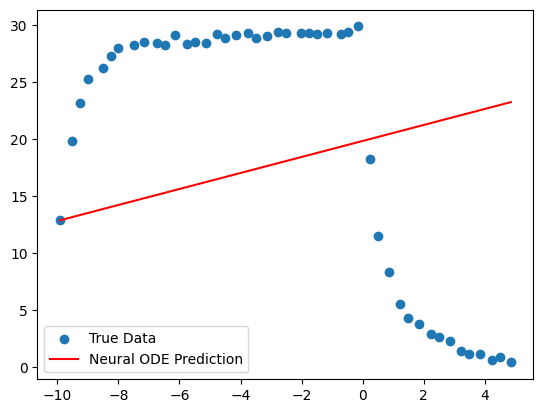

ODEfunction(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=5, bias=True)
    (1): Tanh()
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [32]:
def train_ode_model(t, C, epochs=800, lr=1e-5):
    x0 = C[0].unsqueeze(0) # make shape (1, 1)
    model = ODEfunction(dim=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss() # loss function 
    batch_loss = []
    val_batch_loss = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        C_pred = odeint(model, x0, t)
        loss = criterion(C_pred, C)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d}: Loss = {loss.item():.6f}")

    print(f"Final Loss: {loss.item():.6f}")

    model.eval()
    with torch.no_grad():
        C_pred = odeint(model, x0, t)
        val_loss = criterion(C_pred, C)
        if epoch % 100 == 0:
            print(f"Validation Loss = {val_loss.item():.6f}")
    print(f"Final Validation Loss: {val_loss.item():.6f}")
    
    
    t_ = torch.linspace(0., 1., steps=100)
    plt.scatter((t.numpy() * (t_np.max() - t0) + t0), C_np, label='True Data')
    plt.plot((t_.numpy() * (t_np.max() - t_np.min()) + t0),
            odeint(model, x0, t_).squeeze().detach().numpy(),
            label='Neural ODE Prediction', color='red')
    plt.legend()
    plt.show()
    return model 

train_ode_model(t, C, epochs=5000, lr=1e-3)